In [4]:
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
!tar -xzvf "./nsynth-test.jsonwav.tar.gz"

--2023-01-10 22:18:50--  http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
Resolving download.magenta.tensorflow.org (download.magenta.tensorflow.org)... 172.253.115.128
Connecting to download.magenta.tensorflow.org (download.magenta.tensorflow.org)|172.253.115.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349501546 (333M) [application/gzip]
Saving to: ‘nsynth-test.jsonwav.tar.gz.1’

nsynth-test.jsonwav 100%[===================>] 333.31M  23.0MB/s    in 15s     

2023-01-10 22:19:05 (22.7 MB/s) - ‘nsynth-test.jsonwav.tar.gz.1’ saved [349501546/349501546]

x nsynth-test/
x nsynth-test/audio/
x nsynth-test/audio/guitar_acoustic_010-097-025.wav
x nsynth-test/audio/reed_acoustic_023-050-025.wav
x nsynth-test/audio/guitar_acoustic_010-049-100.wav
x nsynth-test/audio/bass_synthetic_034-039-050.wav
x nsynth-test/audio/brass_acoustic_015-052-075.wav
x nsynth-test/audio/bass_synthetic_134-065-127.wav
x nsynth-test/audio/keyboard_ele

In [5]:
pip install pydub

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile
from pydub import AudioSegment
from IPython.display import Audio, display
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer

import random
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:

df = pd.read_json(f"./nsynth-test/examples.json", orient='index')
df.head(5)

,qualities,pitch,note,instrument_source_str,velocity,instrument_str,instrument,sample_rate,qualities_str,instrument_source,note_str,instrument_family,instrument_family_str
bass_synthetic_068-049-025,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",49,217499,synthetic,25,bass_synthetic_068,656,16000,[dark],2,bass_synthetic_068-049-025,0,bass
keyboard_electronic_001-021-127,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",21,299359,electronic,127,keyboard_electronic_001,40,16000,[],1,keyboard_electronic_001-021-127,4,keyboard
guitar_acoustic_010-066-100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",66,72288,acoustic,100,guitar_acoustic_010,219,16000,[],0,guitar_acoustic_010-066-100,3,guitar
reed_acoustic_037-068-127,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",68,22259,acoustic,127,reed_acoustic_037,387,16000,[reverb],0,reed_acoustic_037-068-127,7,reed
flute_acoustic_002-077-100,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",77,72001,acoustic,100,flute_acoustic_002,86,16000,[reverb],0,flute_acoustic_002-077-100,2,flute


In [5]:
#understand data in columns
print('len of instrument_str unique values', df.instrument_str.unique().shape[0])


#drop note_str
df.instrument_str.value_counts()

len of instrument_str unique values 53


flute_synthetic_000        125
keyboard_acoustic_004      119
bass_synthetic_009         119
vocal_synthetic_003        119
guitar_acoustic_014        117
guitar_acoustic_021        111
organ_electronic_028       111
guitar_acoustic_010        111
mallet_acoustic_062        108
organ_electronic_007       108
bass_synthetic_068         108
keyboard_synthetic_000     108
bass_synthetic_135         107
keyboard_electronic_002    107
bass_synthetic_033         105
guitar_acoustic_015        101
keyboard_electronic_098     99
guitar_electronic_028       97
bass_synthetic_134          97
keyboard_electronic_001     96
bass_synthetic_098          92
keyboard_electronic_003     91
brass_acoustic_006          84
keyboard_electronic_078     81
guitar_electronic_022       74
reed_acoustic_023           73
organ_electronic_057        72
brass_acoustic_046          72
organ_electronic_001        72
organ_electronic_104        71
organ_electronic_113        68
keyboard_electronic_069     65
string_a

In [6]:
#understand data in columns instrument_family_str
print('len of instrument_str unique values', df.instrument_family_str.unique().shape[0])

df.instrument_family_str.value_counts()

len of instrument_str unique values 10


bass        843
keyboard    766
guitar      652
organ       502
string      306
brass       269
reed        235
mallet      202
flute       180
vocal       141
Name: instrument_family_str, dtype: int64

In [7]:
#len of dataframe
print(df.shape[0])

4096


In [8]:
df

,qualities,pitch,note,instrument_source_str,velocity,instrument_str,instrument,sample_rate,qualities_str,instrument_source,note_str,instrument_family,instrument_family_str
bass_synthetic_068-049-025,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",49,217499,synthetic,25,bass_synthetic_068,656,16000,[dark],2,bass_synthetic_068-049-025,0,bass
keyboard_electronic_001-021-127,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",21,299359,electronic,127,keyboard_electronic_001,40,16000,[],1,keyboard_electronic_001-021-127,4,keyboard
guitar_acoustic_010-066-100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",66,72288,acoustic,100,guitar_acoustic_010,219,16000,[],0,guitar_acoustic_010-066-100,3,guitar
reed_acoustic_037-068-127,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",68,22259,acoustic,127,reed_acoustic_037,387,16000,[reverb],0,reed_acoustic_037-068-127,7,reed
flute_acoustic_002-077-100,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",77,72001,acoustic,100,flute_acoustic_002,86,16000,[reverb],0,flute_acoustic_002-077-100,2,flute
...,...,...,...,...,...,...,...,...,...,...,...,...,...
brass_acoustic_006-088-075,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",88,35344,acoustic,75,brass_acoustic_006,43,16000,[reverb],0,brass_acoustic_006-088-075,1,brass
organ_electronic_028-044-100,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",44,187148,electronic,100,organ_electronic_028,440,16000,[dark],1,organ_electronic_028-044-100,6,organ
string_acoustic_071-027-127,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]",27,114253,acoustic,127,string_acoustic_071,609,16000,"[long_release, reverb]",0,string_acoustic_071-027-127,8,string
string_acoustic_057-063-127,"[1, 0, 0, 0, 0, 0, 1, 0, 1, 0]",63,58959,acoustic,127,string_acoustic_057,450,16000,"[bright, nonlinear_env, reverb]",0,string_acoustic_057-063-127,8,string


In [9]:
def df_to_data(df):
    data = pd.get_dummies(df, columns=['instrument_source_str','instrument_str'])
    s = df['qualities_str']
    mlb = MultiLabelBinarizer()

    qual = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df.index)
    data = pd.concat([data, qual], axis=1)

    #note_str: values are same as title, no generalizable info
    #instrument_family_str: value is in a more 'information dense' version for instrument_str which will be put into a dummy format
    #qualities: were turned into dummy

    data = data.drop(columns=['note_str','instrument_family_str','qualities','qualities_str'])
    data['name'] = data.index
    data = data.reset_index(drop=True)
    return data

In [10]:
data = df_to_data(df)

In [11]:
def spectrogramify(instance, phase, nperseg=1000):
    # instance: record name
    # phase: train, val, or test
    source = "nsynth-" + str(phase) + "/audio/" + str(instance) + ".wav"
    sample_rate, samples = wavfile.read(source)
    frequencies, times, spectrogram = signal.stft(samples, fs=sample_rate, nperseg=nperseg)

    return sample_rate, frequencies, times, spectrogram
def show_spectro(times, frequencies, spectrogram):
    f = plt.figure()
    f.set_figwidth(5)
    f.set_figheight(3)

    plt.pcolormesh(times, frequencies, np.abs(spectrogram))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim([0, 2000])
    plt.show()
    
def spectro_to_wav(spectrogram, sample_rate = 16000):
    _, gen = signal.istft(spectrogram, sample_rate)
    wavfile.write("output.wav", sample_rate, gen.astype(np.int16))
    return True

def spectro_to_audio(spectrogram, sample_rate = 16000):
    spectro_to_wav(spectrogram, sample_rate)
    wav = "output.wav"
    display(Audio(wav, autoplay=True))
    
def decompose_spect(y):
    y_real = []
    y_imag = []
    for i in range(len(y)):
        y_real.append(y[i].real)
        y_imag.append(y[i].imag)
    return np.array(y_real), np.array(y_imag)

def recompose_spect(y_real, y_imag):
    y = 1j*y_imag
    y += y_real
    return np.array(y)
     


<ipython-input-11-0e058c6ee6ca>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(times, frequencies, np.abs(spectrogram))


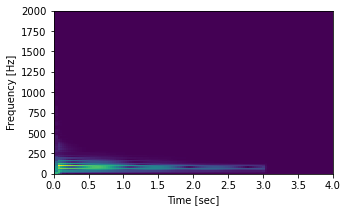

In [12]:
sample_rate, frequencies, times, spectrogram = spectrogramify('bass_electronic_018-023-075','test')
show_spectro(times, frequencies, spectrogram)

In [13]:
#looking at the foiour transform
instance = 'bass_electronic_018-023-075'
source = "nsynth-test/audio/" + str(instance) + ".wav"
sample_rate, samples = wavfile.read(source)

In [14]:
samples.shape

(64000,)

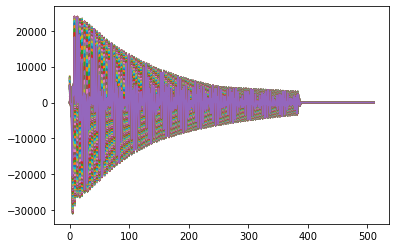

In [15]:
wav_og = samples.reshape(512,125)
plt.plot(wav_og)

In [16]:
#creating a 512, by 125 image seems much better. Lets start with this before doing the shot form foriour transform

In [17]:
# Lets build a dataloader

class WavOriginalDataset(Dataset):
    def __init__(self):
        self.imgs_path = "nsynth-test/audio/" 
        file_list_data = glob.glob(self.imgs_path + "*")
        self.vector_path = ""
        #print(file_list_data)
        self.data = []
        for file_path in file_list_data:
            file_name = file_path.split("/")[-1].split(".")[0]
            vector = data[data['name'] == file_name]
            lv = list(vector.values)
            a = np.array(lv[0][:-1])
            vec = np.array(list(lv[0][:-1]))
            img_path = file_name
            self.data.append([vec, img_path])
        random.shuffle(self.data)
        self.img_dim = (501, 129)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        vector, y = self.data[idx]
        source = "nsynth-test/audio/" + str(y) + ".wav"
        sample_rate, samples = wavfile.read(source)
        img_tensor = torch.from_numpy(samples)
        vec = torch.tensor(vector)
        return vec.float(), img_tensor.float()

In [18]:
dataset = WavOriginalDataset()
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
dataset.__len__()


4096

<ipython-input-17-88dc751b1878>:26: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484782168/work/torch/csrc/utils/tensor_numpy.cpp:178.)
  img_tensor = torch.from_numpy(samples)


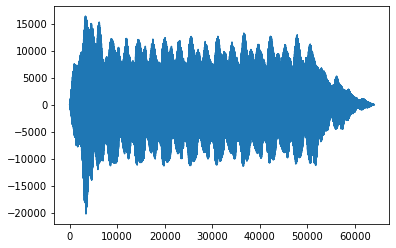

In [19]:
abc = dataset.__getitem__(125)
plt.plot(abc[1])

In [18]:
print('spectogram sum:', spectrogram.sum())

vector = data[data['name'] == 'organ_electronic_057-061-100']
lv = list(vector.values)
a = np.array(lv[0][:-1])
abc = np.array(list(lv[0][:-1]))
torch.tensor(abc)
abc

spectogram sum: (11.288176+0.0024033906j)


array([    61, 259543,    100,    701,  16000,      1,      6,      0,
            1,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            1,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            1,      0,      0,      0,      0,      0,      0,      0,
            0])

In [24]:
# Lets build a dataloader

class CustomDataset(Dataset):
    def __init__(self):
        self.imgs_path = "nsynth-test/audio/" 
        file_list_data = glob.glob(self.imgs_path + "*")
        self.vector_path = ""
        #print(file_list_data)
        self.data = []
        for file_path in file_list_data:
            file_name = file_path.split("/")[-1].split(".")[0]
            vector = data[data['name'] == file_name]
            lv = list(vector.values)
            a = np.array(lv[0][:-1])
            vec = np.array(list(lv[0][:-1]))
            img_path = file_name
            self.data.append([vec, img_path])
        random.shuffle(self.data)
        self.img_dim = (501, 129)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        vector, y = self.data[idx]
        sample_rate, frequencies, times, spectrogram = spectrogramify(y,'test')
        img_tensor = torch.from_numpy(spectrogram)
        vec = torch.tensor(vector)
        return vec.float(), img_tensor.float()

In [18]:
dataset = CustomDataset()
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
dataset.__len__()

NameError: name 'CustomDataset' is not defined

In [26]:
abc = dataset.__getitem__(0)

<ipython-input-24-7fc07e42262d>:27: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484782168/work/aten/src/ATen/native/Copy.cpp:250.)
  return vec.float(), img_tensor.float()


In [27]:
abc[1].shape

torch.Size([501, 129])

### Load data and build model

In [20]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [21]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [22]:
dataiter = iter(train_loader)
vector, spec = next(dataiter)

In [31]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.upscale_1 = nn.Linear(73, 16000)
        self.upscale_2 = nn.Linear(16000, 125*512)
        
        self.conv1 = nn.Conv2d(1, 6, 5, padding = 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.convLast = nn.Conv2d(16, 1, 3)
        

    def forward(self, x):
        s = x.shape[0]
        x = F.relu(self.upscale_1(x))
        x = F.relu(self.upscale_2(x))
        #512 by 125 for non for fourier transformed 
        #501 by 129 for ft
        x = x.reshape(s,1,512,125)
        x = F.relu(self.conv1(x))
        #print('conv1: ', x.shape)
        x = F.relu(self.conv2(x))
        #print('conv2: ', x.shape)
        x = F.relu(self.convLast(x))
        #print('conv3: ', x.shape)
        x = x.flatten(2)
        x = x.squeeze(1)

        
        return x


net = Net()
print(net)

Net(
  (upscale_1): Linear(in_features=73, out_features=16000, bias=True)
  (upscale_2): Linear(in_features=16000, out_features=64000, bias=True)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(5, 5))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (convLast): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
)


In [32]:
num_epochs = 1
batch_size = 16
learning_rate = 0.005
model = None
model = Net()


# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


# Train the model
total_step = len(train_loader)


In [33]:
loss_array = []
for epoch in range(num_epochs):
    
    for i, (vector, spec) in enumerate(train_loader):  
    
        spec = spec
        
        outputs = model(vector)
        loss = rich_loss(outputs, spec)
        loss_array.append(loss)
        # Backward and optimize
        print(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

-29.412304
tensor(39.8086, grad_fn=<SubBackward0>)
38.979992
tensor(29.1971, grad_fn=<SubBackward0>)
-18.74776
tensor(40.6973, grad_fn=<SubBackward0>)
300.88037
tensor(35.5697, grad_fn=<SubBackward0>)
34.997368
tensor(19.2946, grad_fn=<SubBackward0>)
15.766708
tensor(44.8815, grad_fn=<SubBackward0>)
-10.925514
tensor(20.7373, grad_fn=<SubBackward0>)
18.107874
tensor(24.7401, grad_fn=<SubBackward0>)
329.4029
tensor(-0.8141, grad_fn=<SubBackward0>)
356.6165
tensor(-6.9330, grad_fn=<SubBackward0>)
-0.10619354
tensor(28.4380, grad_fn=<SubBackward0>)
518.5443
tensor(-2.9641, grad_fn=<SubBackward0>)
-14.100365
tensor(24.8651, grad_fn=<SubBackward0>)
535.7146
tensor(-9.4898, grad_fn=<SubBackward0>)
-52.33235
tensor(41.3636, grad_fn=<SubBackward0>)
512.7733
tensor(2.2906, grad_fn=<SubBackward0>)
427.48578
tensor(0.1535, grad_fn=<SubBackward0>)
-5.9682307
tensor(22.6663, grad_fn=<SubBackward0>)
191.06862
tensor(35.4859, grad_fn=<SubBackward0>)
311.52924
tensor(10.4359, grad_fn=<SubBackward0>)
-

### Created Loss function

In [ ]:
dataiter = iter(train_loader)
avg = []
for x in range(4000):
    abc = dataset.__getitem__(x)
    m = abc[1].numpy().mean()
    avg.append(m)
    
np.array(avg).mean()
#average of 122 in net fill



[9.654212951660157e-07,
 4.680475234985352e-06,
 6.65774154663086e-07,
 -8.022823333740234e-07,
 6.362430572509766e-07,
 9.756065368652344e-07,
 2.748690986633301e-06,
 1.2852573394775391e-06,
 2.456809425354004e-06,
 3.84833984375e-06,
 2.6849250793457033e-06,
 -2.1219062805175781e-07,
 2.793897819519043e-06,
 2.714148712158203e-06,
 1.8425790786743164e-06,
 4.124008560180664e-06,
 3.6516704559326174e-06,
 3.0875463485717774e-06,
 5.17329216003418e-07,
 3.439373779296875e-06,
 3.5314529418945314e-06,
 1.7025764465332031e-06,
 4.487623977661133e-06,
 -6.378582000732421e-07,
 -1.0382080078125e-08,
 7.159149169921875e-07,
 2.9070728302001954e-06,
 -6.772880554199219e-07,
 8.628973007202148e-07,
 2.2327516555786134e-06,
 3.815608978271485e-06,
 2.927619171142578e-06,
 2.8259328842163087e-06,
 2.9882034301757813e-06,
 3.2141067504882814e-06,
 4.071359634399414e-06,
 -1.1049045562744141e-06,
 3.2572845458984376e-06,
 2.9435659408569337e-06,
 8.019262313842773e-07,
 2.859927749633789e-06,
 2

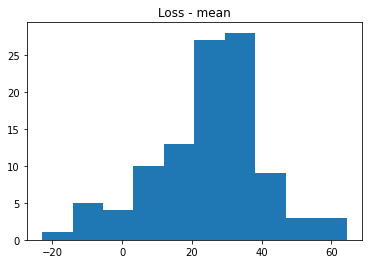

In [48]:
#lets see the average loss, we can also look at how the weights of cnn change per layer


a = [t.detach().item() for t in loss_array]
m = np.array(a).mean()
plt.hist(a)
plt.title('Loss - mean')
a7 = [x / 10e6 for x in a]
a7

In [26]:
#lets create a loss function that works better
#We want it to actually produce values, it is going to zero fast because of the sparsity. 
# lets code in that we will lower loss based on the sum off all values, thus encouraging the model to produce more
# information.

#We should try a ratio, relative to how filled up we want it to be. Lets find the average filled up 
#pixel amount and reduce loss for being close to that. 
#we see the net fill is extremly low, and then bounces around. 

#What is the overall magnitude of loss for a simple cnn?
#between 0 and 5

#by subtracting from the avergae it is just generalizing a pattern
def rich_loss(outputs, actual):
    l = criterion(outputs, actual)
    l = l/10e5
    
    a = [x.numpy().mean() for x in actual]
    om = np.array(a).mean()
    print(om)
    l = l - (om/10)
    return l

def rich_loss_med(outputs, actual):
    l = criterion(outputs, actual)
    l = l/10e5
    a = [x.numpy().mean() for x in actual]
    om = np.array(a).mean()
    
    #distance from actual spectogram median
    r = abs(l - 122)
    l = l + r
    
    return l
    

In [ ]:
loss

In [ ]:
t = torch.rand(32,1,512,125)

In [ ]:
t = t.flatten(2)

In [ ]:
t.squeeze(1).shape

In [28]:
model

Net(
  (upscale_1): Linear(in_features=73, out_features=16000, bias=True)
  (upscale_2): Linear(in_features=16000, out_features=64000, bias=True)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(5, 5))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (convLast): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
)

conv3:  torch.Size([1, 1, 512, 125])


Text(0.5, 1.0, 'Loss - mean')

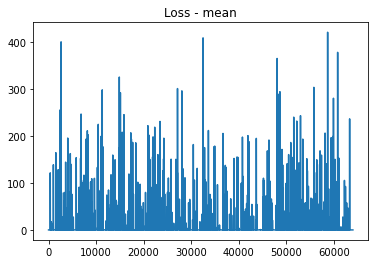

In [29]:
lv = list(data.iloc[2000,:])
a = np.array(lv[:-1])
vec = np.array(list(lv[:-1]))
vec = torch.tensor(vec)
vec = vec.float()
vec = vec.reshape(1,73)
output = model(vec)
no = output.detach().numpy()
no = no.squeeze(0)
plt.plot(no)
plt.title('Loss - mean')
#output with loss lowered by total magnitude with MSE

In [85]:
net = []
for x in range(10):
    lv = list(data.iloc[x,:])
    a = np.array(lv[:-1])
    vec = np.array(list(lv[:-1]))
    vec = torch.tensor(vec)
    vec = vec.float()
    vec = vec.reshape(1,73)
    output = model(vec)
    no = output.detach().numpy()
    no = no.squeeze(0)
    net.append(no)
net = np.array(net)

net.var()

226.50063

In [86]:
net.mean()

2.6181765

In [93]:
for z in net:
    print(plt.scatter(z))

TypeError: scatter() missing 1 required positional argument: 'y'

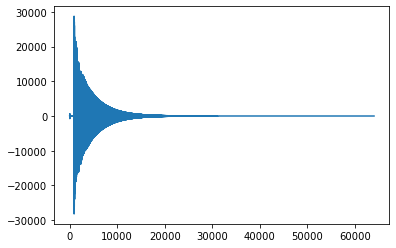

In [84]:
y = data.iloc[13,-1]
source = "nsynth-test/audio/" + str(y) + ".wav"
sample_rate, samples = wavfile.read(source)
plt.plot(samples)

In [51]:
data.iloc[4,-1]

'flute_acoustic_002-077-100'

In [ ]:
output = model(vec)

In [ ]:
no = output.detach().numpy()
no = no.squeeze(0)

In [ ]:
no

In [ ]:
no.sum()

In [ ]:
no.sum()

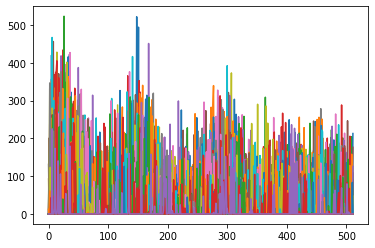

In [97]:
plt.plot(no.reshape(512,125))



Here we are comparing 3 different loss functions for a pretty difficult CNN upscaling task. 


Factors: Loss Function, Batch size at 1 for rich loss

Metrics: layer weights, final graph, overall weights of output


MSE -> always default to zero

rich_loss mean -> good, but sloopy results. 

rich_loss distance from train median -> incoming

Notes: must scale loss, it is extremly fucking large and based off investigations into standard mnist cnn, the loss is between 0 and 5, and not in the range 10e8, i thought log wouldnt be descriptive enough. perhaps devision isnt either. I should look into variance of the natrual loss

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'With non scaled loss')

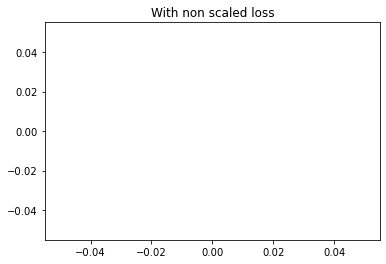

In [4]:
x = np.zeros(64000)
y = np.zeros(64000)
plt.plot(x,y)
plt.title('With non scaled loss')
